# Smilegate UnSmile Dataset Tutorial

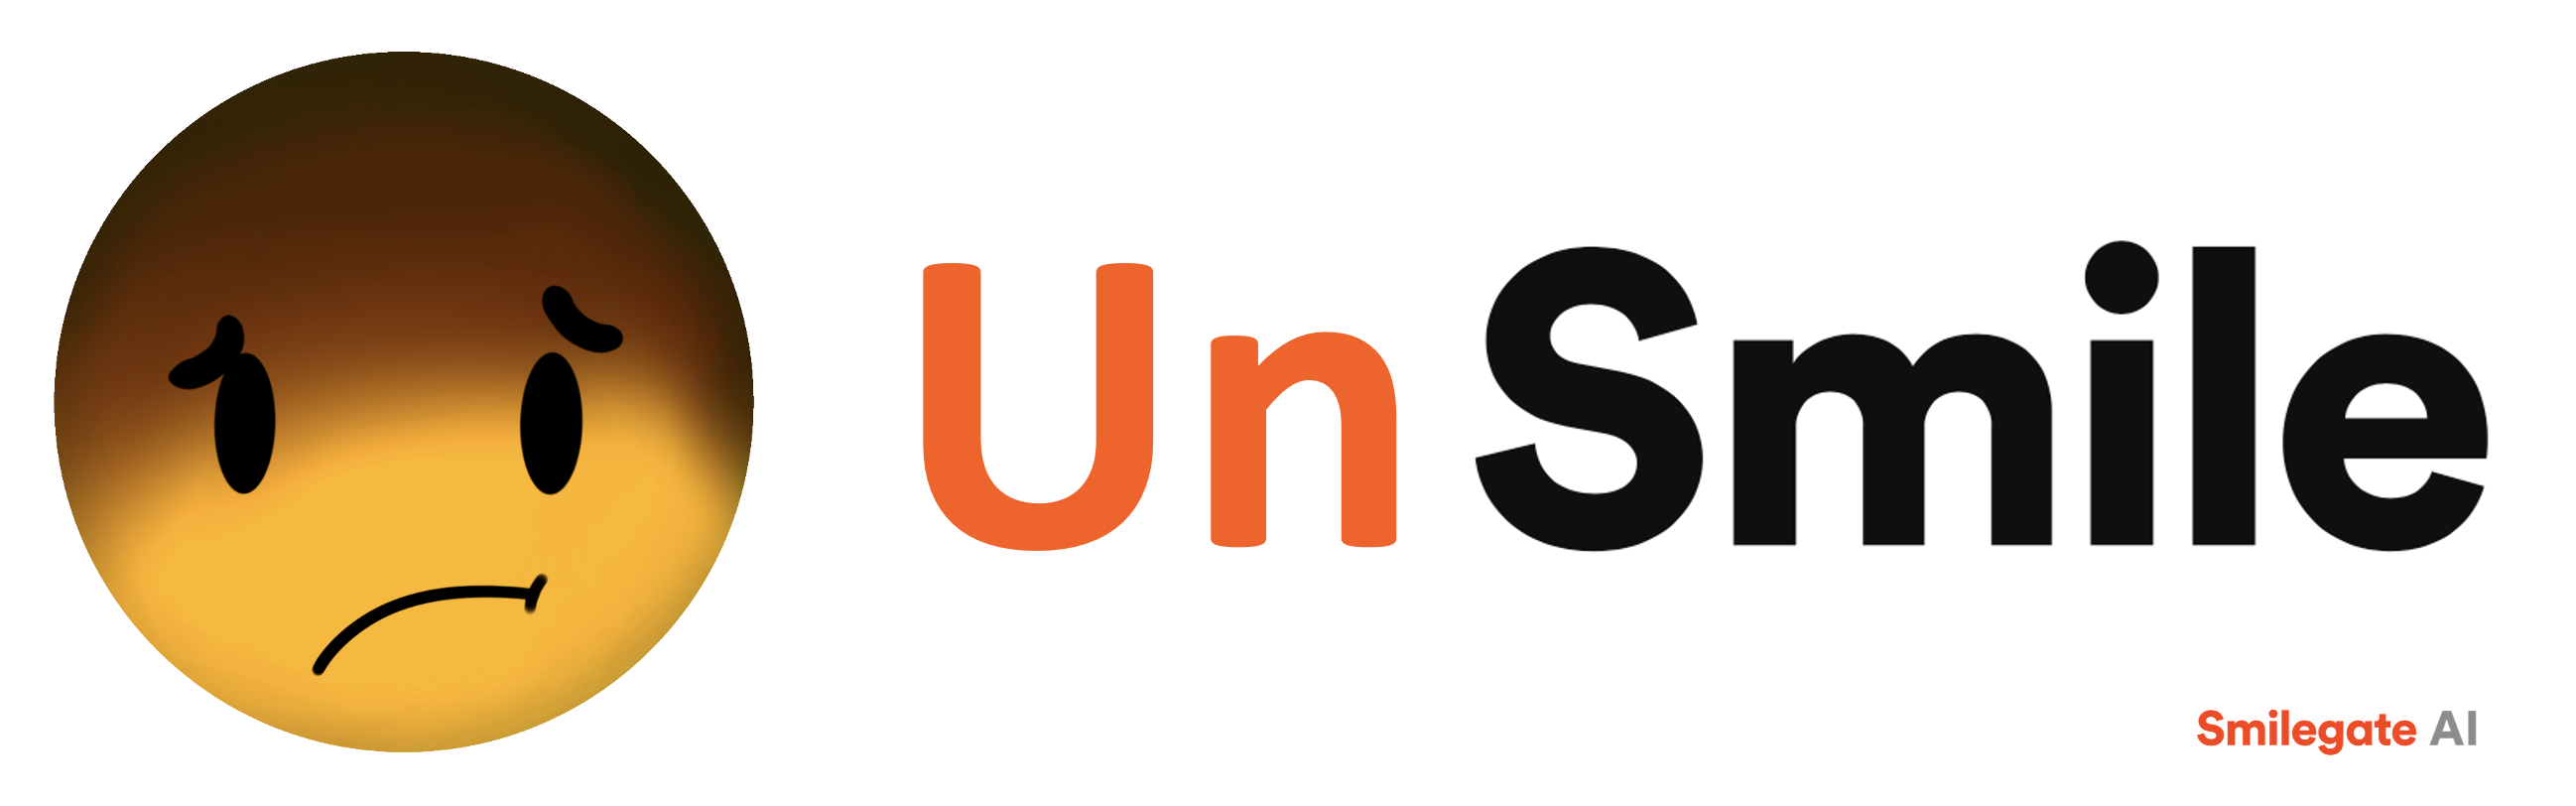

[Smilegate AI 센터](https://smilegate.ai) 에서 공개하는 한국어 혐오표현 "☹️ [UnSmile](https://github.com/smilegate-ai/korean_unsmile_dataset)" 데이터셋 사용을 위한 tutorial 실습 노트북입니다.

> Contact      
```
* 스마일게이트 AI센터 (smilegate_ai@smilegate.com)
```

Smilegate AI `UnSmile`의 `소스코드 및 baseline 모델`은 [Apache 2.0](LICENSE.apache-2.0) 라이선스 하에 공개되어 있습니다. 

# 0. 환경설정

본 실습에서는 Huggingface [Transformers](https://github.com/huggingface/transformers)와 [Datasets](https://github.com/huggingface/datasets) 라이브러리를 사용합니다.

In [ ]:
!pip install transformers
!pip install datasets==1.17.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 12.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.3/306.3 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 17.0 MB/s eta 0:00:0

# 1. 데이터셋 load

Huggingface Datasets를 통해 데이터를 load해보겠습니다.

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset('smilegate-ai/kor_unsmile')

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/290k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/smilegate-ai--kor_unsmile-e0f75c6e3be1af78/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset["train"][0]

{'문장': '일안하는 시간은 쉬고싶어서 그런게 아닐까',
 '여성/가족': 0,
 '남성': 0,
 '성소수자': 0,
 '인종/국적': 0,
 '연령': 0,
 '지역': 0,
 '종교': 0,
 '기타 혐오': 0,
 '악플/욕설': 0,
 'clean': 1,
 '개인지칭': 0,
 'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

In [ ]:
unsmile_labels = ["여성/가족","남성","성소수자","인종/국적","연령","지역","종교","기타 혐오","악플/욕설","clean"]
# 개인지칭의 경우, 추가 정보이므로 분류 대상에서 제외했습니다.

# 2. Model load

학습을 위해 Pretrained language model (PLM) 을 활용해보겠습니다.

In [ ]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
import torch
import numpy as np

In [ ]:
model_name = 'beomi/kcbert-base'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

bert model에 학습 데이터 전달을 위해 tokenizing 작업을 수행합니다.

In [ ]:
def preprocess_function(examples):
    tokenized_examples = tokenizer(str(examples["문장"]))
    tokenized_examples['labels'] = torch.tensor(examples["labels"], dtype=torch.float)
    # multi label classification 학습을 위해선 label이 float 형태로 변형되어야 합니다.
    # huggingface datasets 최신 버전에는 'map' 함수에 버그가 있어서 변형이 올바르게 되지 않습니다.
    
    return tokenized_examples

In [ ]:
tokenized_dataset = dataset.map(preprocess_function)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'labels', 'attention_mask', 'token_type_ids'])

  0%|          | 0/3737 [00:00<?, ?ex/s]

  0%|          | 0/15005 [00:00<?, ?ex/s]

In [ ]:
tokenized_dataset['train'][0]

{'labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 'input_ids': tensor([    2,  2458, 15751, 24930, 24351, 29278, 17038, 11631,     3]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])}

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
num_labels=len(unsmile_labels) # Label 갯수

model = BertForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels, 
    problem_type="multi_label_classification"
)
model.config.id2label = {i: label for i, label in zip(range(num_labels), unsmile_labels)}
model.config.label2id = {label: i for i, label in zip(range(num_labels), unsmile_labels)}

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

In [ ]:
model.config.label2id

{'여성/가족': 0,
 '남성': 1,
 '성소수자': 2,
 '인종/국적': 3,
 '연령': 4,
 '지역': 5,
 '종교': 6,
 '기타 혐오': 7,
 '악플/욕설': 8,
 'clean': 9}

# 3. Model training

In [ ]:
from sklearn.metrics import label_ranking_average_precision_score

In [ ]:
def compute_metrics(x):
    return {
        'lrap': label_ranking_average_precision_score(x.label_ids, x.predictions),
    }

In [ ]:
batch_size = 64 # 64 batch는 colab pro에서 테스트되었습니다.

In [ ]:
args = TrainingArguments(
    output_dir="model_output",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='lrap',
    greater_is_better=True,
)

trainer = Trainer(
    model=model, 
    args=args, 
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["valid"], 
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: 문장, 성소수자, 개인지칭, 인종/국적, 남성, 악플/욕설, 연령, 기타 혐오, 지역, 여성/가족, 종교, clean. If 문장, 성소수자, 개인지칭, 인종/국적, 남성, 악플/욕설, 연령, 기타 혐오, 지역, 여성/가족, 종교, clean are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 15005
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1175
  Number of trainable parameters = 108926218
You're using a Be

Epoch,Training Loss,Validation Loss,Lrap
1,No log,0.146757,0.861707
2,No log,0.127553,0.874910
3,0.171600,0.124585,0.882816
4,0.171600,0.127010,0.882264
5,0.077300,0.131745,0.877943


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: 문장, 성소수자, 개인지칭, 인종/국적, 남성, 악플/욕설, 연령, 기타 혐오, 지역, 여성/가족, 종교, clean. If 문장, 성소수자, 개인지칭, 인종/국적, 남성, 악플/욕설, 연령, 기타 혐오, 지역, 여성/가족, 종교, clean are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3737
  Batch size = 64
Saving model checkpoint to model_output/checkpoint-235
Configuration saved in model_output/checkpoint-235/config.json
Model weights saved in model_output/checkpoint-235/pytorch_model.bin
tokenizer config file saved in model_output/checkpoint-235/tokenizer_config.json
Special tokens file saved in model_output/checkpoint-235/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: 문장, 성소수자, 개인지칭, 인종/국적, 남성, 악플/욕설, 연령, 기타 혐오, 지역, 여성/가족

TrainOutput(global_step=1175, training_loss=0.11434293625202585, metrics={'train_runtime': 854.7067, 'train_samples_per_second': 87.779, 'train_steps_per_second': 1.375, 'total_flos': 2415117214625892.0, 'train_loss': 0.11434293625202585, 'epoch': 5.0})

In [ ]:
trainer.save_model()

Saving model checkpoint to model_output
Configuration saved in model_output/config.json
Model weights saved in model_output/pytorch_model.bin
tokenizer config file saved in model_output/tokenizer_config.json
Special tokens file saved in model_output/special_tokens_map.json


# 4. Model test

직접 학습하신 모델을 사용하실 경우, 아래 코드로 실행해주세요

In [ ]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(
    model = model,
    tokenizer = tokenizer,
    device=0,
    return_all_scores=True,
    function_to_apply='sigmoid'
    )

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


기학습된 모델을 사용하실 경우, 아래 코드로 실행해주세요

In [ ]:
# from transformers import TextClassificationPipeline, BertForSequenceClassification, AutoTokenizer

# model_name = 'smilegate-ai/kor_unsmile'

# model = BertForSequenceClassification.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# pipe = TextClassificationPipeline(
#     model=model,
#     tokenizer=tokenizer,
#     device=0,     # cpu: -1, gpu: gpu number
#     return_all_scores=True,
#     function_to_apply='sigmoid'
#     )

In [ ]:
for result in pipe("이래서 여자는 게임을 하면 안된다")[0]:
    print(result)

{'label': '여성/가족', 'score': 0.896464467048645}
{'label': '남성', 'score': 0.027022438123822212}
{'label': '성소수자', 'score': 0.00946902483701706}
{'label': '인종/국적', 'score': 0.013971302658319473}
{'label': '연령', 'score': 0.01120996754616499}
{'label': '지역', 'score': 0.016094250604510307}
{'label': '종교', 'score': 0.009250459261238575}
{'label': '기타 혐오', 'score': 0.011313151568174362}
{'label': '악플/욕설', 'score': 0.021428311243653297}
{'label': 'clean', 'score': 0.11717435717582703}


# 5. Model evaluation

In [ ]:
def get_predicated_label(output_labels, min_score):
    labels = []
    for label in output_labels:
        if label['score'] > min_score:
            labels.append(1)
        else:
            labels.append(0)
    return labels

In [ ]:
import tqdm
from transformers.pipelines.base import KeyDataset

predicated_labels = []

for out in tqdm.tqdm(pipe(KeyDataset(dataset['valid'], '문장'))):
    predicated_labels.append(get_predicated_label(out, 0.5))

Disabling tokenizer parallelism, we're using DataLoader multithreading already
100%|██████████| 3737/3737 [00:56<00:00, 65.73it/s]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(dataset['valid']['labels'], predicated_labels))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       394
           1       0.86      0.85      0.86       334
           2       0.88      0.84      0.86       280
           3       0.87      0.80      0.83       426
           4       0.86      0.86      0.86       146
           5       0.90      0.91      0.90       260
           6       0.87      0.87      0.87       290
           7       0.69      0.34      0.46       134
           8       0.73      0.63      0.68       786
           9       0.77      0.74      0.76       935

   micro avg       0.81      0.76      0.79      3985
   macro avg       0.82      0.77      0.79      3985
weighted avg       0.81      0.76      0.78      3985
 samples avg       0.77      0.77      0.77      3985



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
